<a href="https://colab.research.google.com/github/mostafa-ja/LLM_from_scratch/blob/main/GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Base model

In [1]:
import os
import math
import time
import inspect
import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass

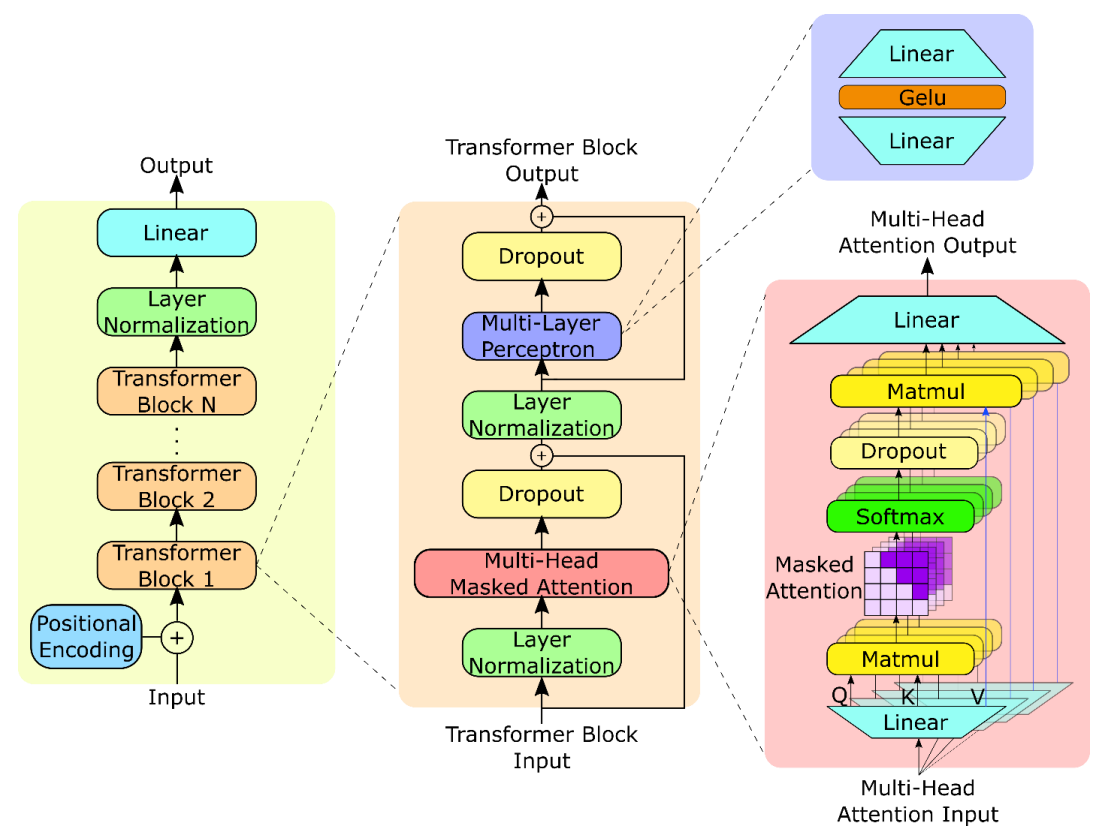


To use **multi-head attention** efficiently, we follow these steps:

* Let:

  * `nh` = number of heads (`self.n_head`)
  * `hs` = head size (`C // nh`), so `C = nh × hs`

### 🧠 Step-by-step process:

1. **Compute all queries, keys, and values (Q, K, V) for all Heads in a single linear layer**:

   ```python
   qkv = self.c_attn(x)  # shape: (B, T, 3 * C) , C = nh * hs
   ```

   This projects the input embeddings to Q, K, and V all at once, combining them into one tensor for efficiency.

2. **Split the QKV tensor into separate Q, K, and V**:

   ```python
   q, k, v = qkv.split(C, dim=2)  # each of shape: (B, T, C)
   ```

   Each of these still represents all heads together in a flat embedding space.

3. **Reshape to separate heads, and prepare for batched matrix multiplication**:

   ```python
   q = q.view(B, T, nh, hs).transpose(1, 2)  # shape: (B, T, C) > (B, T, nh, hs) > (B, nh, T, hs)
   ```

   This reshapes each tensor to expose the `nh` heads as a separate dimension and transposes it so the head dimension (`nh`) comes before the sequence dimension (`T`).

   Repeat for `k` and `v`.

4. **Why this shape matters**:
   With shape `(B, nh, T, hs)`, the attention computation internally treats the batch as having `B × nh` parallel sequences. This structure allows efficient batched matrix multiplications:

   * Each attention head independently computes dot products and attention scores.
   * Computation is effectively parallel over both batch size (`B`) and number of heads (`nh`).


This structure enables highly efficient and scalable attention mechanisms, especially when using optimized implementations like Flash Attention.




In [2]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.register_buffer('bias', torch.tril(torch.ones(config.block_size, config.block_size))
                                    .view(1,1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        qkv = self.c_attn(x) # shape: (B, T, 3 * C)
        q, k, v = qkv.split(self.n_embd, dim=2) # Each of shape (B, T, C)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        att = (q @ k.transpose(-2,-1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1,2).contiguous().view(B, T, C) # (B, nh, T, hs) → (B, T, nh, hs) → (B, T, nh * hs) = (B, T, C)

        y = self.c_proj(y)

        return y


In [3]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu    = nn.GELU(approximate='tanh')
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.NANOGPT_SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x


In [4]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

The line:

```python
self.transformer["wte"].weight = self.lm_head.weight
```

**means that the input embedding weights and the output projection weights are shared.**

### Let's break this down:

* `self.transformer["wte"]` is the **word token embedding layer**: it maps token IDs to dense vectors of size `n_embd`.
* `self.lm_head` is the **final linear layer** used to project the transformer output back to vocabulary logits (for prediction).

In detail:

* The **embedding layer** (`nn.Embedding(config.vocab_size, config.n_embd)`) has weights of shape `(vocab_size, n_embd)`.
* The **output layer** (`nn.Linear(config.n_embd, config.vocab_size, bias=False)`) has weights of shape `(vocab_size, n_embd)` — *notice the same shape* (but in transposed order).

By doing:

```python
self.transformer["wte"].weight = self.lm_head.weight
```

you **force both layers to use the exact same weight tensor** (i.e., no duplication of memory). This is called **weight tying** or **weight sharing**.



---

### Weight Initialization in GPT

In transformer-based models like GPT, proper weight initialization is critical for stable training and efficient convergence. The `_init_weights` method in the `GPT` class ensures this by initializing weights according to module type and depth.

#### Initialization Strategy

The method applies the following rules based on the type of submodule (`nn.Module`):

1. **Linear Layers (`nn.Linear`)**:

   * Initialized with a normal distribution (`mean=0.0`) and standard deviation of **0.02** by default.
   * If the layer has the `NANOGPT_SCALE_INIT` flag (used in `MLP` and `CausalSelfAttention`), the standard deviation is adjusted as:

     $$
     \text{std} = \frac{0.02}{\sqrt{2 \times \text{n\_layer}}}
     $$

     This accounts for the two residual paths in each transformer block (attention and MLP).
   * Biases are initialized to zero.

2. **Embedding Layers (`nn.Embedding`)**:

   * Both token (`wte`) and position (`wpe`) embeddings are initialized with a normal distribution (std = **0.02**).

3. **Layer Normalization (`nn.LayerNorm`)**:

   * Not explicitly re-initialized since PyTorch’s default initialization (scale = 1, bias = 0) is sufficient.

---

### Why Use the Same Scale in All Layers for Linear Layers (`nn.Linear`)?

While it may seem intuitive to adjust the initialization scale based on a layer’s position — since deeper layers pass through fewer residual connections — GPT uses the **same scaled initialization for all layers**, based on the total number of blocks. Here's why:

* **Residual Connections Preserve Inputs**: Each block adds its output to its input, rather than replacing it, which maintains stable signal propagation.

---

### Why 0.02?

Although 0.02 might seem arbitrary, it aligns closely with the theoretical values of Xavier initialization for common hidden dimensions in GPT-style models:

| Hidden Dimension | 1 / √(Hidden Dimension) |
| ---------------- | ----------------------- |
| 768              | 0.036                   |
| 1024             | 0.031                   |
| 1280             | 0.028                   |
| 1600             | 0.025                   |

Thus, **0.02 is a conservative and practical default** that works well in combination with normalization and residual connections.




In [5]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd)
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # weight sharing scheme
        self.transformer["wte"].weight = self.lm_head.weight

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        # idx is of shape (B, T)
        B, T = idx.size()
        assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"

        # forward the token and position embeddings
        pos = torch.arange(0, T, dtype=torch.long, device=idx.device).unsqueeze(0)  # shape (1, T)
        pos_emb = self.transformer["wpe"](pos)               # (1, T, n_embd)
        tok_emb = self.transformer["wte"](idx)               # (B, T, n_embd)
        x = tok_emb + pos_emb                                # broadcasting (B, T, n_embd)

        # forward the blocks of the transformer
        for block in self.transformer["h"]:
            x = block(x)

        # final layernorm and output projection
        x = self.transformer["ln_f"](x)
        logits = self.lm_head(x)                             # (B, T, vocab_size)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

        return logits, loss


In [6]:
@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens
    n_layer: int = 12 # number of transformer layers
    n_head: int = 12 # number of heads in multi-head attention
    n_embd: int = 768 # embedding dimension

# Simple test

In [7]:
# Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-05-03 20:47:31--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-05-03 20:47:31 (25.5 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [8]:
!pip install tiktoken

In [9]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')

with open('input.txt', 'r') as f:
    text = f.read()

text = text[:1000]
tokens = enc.encode(text)
print(f"There are {len(tokens)} tokens")

There are 285 tokens


In [10]:
B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
x = buf[:-1].view(B,T)
y = buf[1:].view(B,T)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GPT(GPTConfig())
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {num_params}")

Total parameters: 124439808


In [47]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for i in range(10):
  optimizer.zero_grad()
  logits, loss = model(x.to(device),y.to(device))
  loss.backward()
  optimizer.step()
  print(f"step {i}, Loss : {loss.item()}")



step 0, Loss : 11.06688404083252
step 1, Loss : 7.3158698081970215
step 2, Loss : 5.650364398956299
step 3, Loss : 4.5834059715271
step 4, Loss : 4.469760417938232
step 5, Loss : 3.5176796913146973
step 6, Loss : 3.2235183715820312
step 7, Loss : 2.8106191158294678
step 8, Loss : 2.5459651947021484
step 9, Loss : 2.347970962524414


# New Section

In [9]:
class DataLoaderLite:
    def __init__(self, B, T):
        self.B = B
        self.T = T

        with open('input.txt', "r") as f:
            text = f.read()

        enc = tiktoken.get_encoding('gpt2')
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens)
        print(f"1 epoch = {len(self.tokens) // (B * T)} batches")

        # stat
        self.current_position = 0

    def next_batch(self):
        B, T = self.B, self.T
        buf = self.tokens[self.current_position: self.current_position+(B*T + 1)]
        x = (buf[:-1]).view(B, T)
        y = (buf[1:]).view(B,T)

        self.current_position += B * T
        if self.current_position + (B*T+1) > len(self.tokens):
            self.current_position = 0
        return x,y

In [57]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

train_loader = DataLoaderLite(B=4, T=32)

model = GPT(GPTConfig())
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

for i in range(10):
  optimizer.zero_grad()
  x, y = train_loader.next_batch()
  logits, loss = model(x.to(device),y.to(device))
  loss.backward()
  optimizer.step()
  print(f"step {i}, Loss : {loss.item()}")


Device: cpu
1 epoch = 2640 batches
step 0, Loss : 11.057626724243164
step 1, Loss : 9.81591510772705
step 2, Loss : 9.06009578704834
step 3, Loss : 9.207348823547363
step 4, Loss : 8.667938232421875
step 5, Loss : 8.373002052307129
step 6, Loss : 9.010164260864258
step 7, Loss : 8.875380516052246
step 8, Loss : 8.1599702835083
step 9, Loss : 8.004850387573242


# New Section

In [14]:
import torch
import numpy as np
import tiktoken
from torch.nn.utils import clip_grad_norm_
import time
from tqdm import tqdm

# ==== Set Seed for Reproducibility ====
def set_seed(seed=1337):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


# ==== Random Batch Generator ====
class RandomBatchGenerator:
    def __init__(self, file_path='input.txt', block_size=128, batch_size=32,
                 device='cpu', split='train', split_ratio=0.9, encoding_name='gpt2'):
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device

        # Load and tokenize text
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        enc = tiktoken.get_encoding(encoding_name)
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens, dtype=torch.long)

        # Train/Val split
        split_idx = int(len(self.tokens) * split_ratio)
        if split == 'train':
            self.tokens = self.tokens[:split_idx]
        elif split == 'val':
            self.tokens = self.tokens[split_idx:]
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.max_start = len(self.tokens) - block_size - 1
        if self.max_start <= 0:
            raise ValueError("block_size too large for the dataset.")

    def next_batch(self):
        #idx = torch.randint(0, self.max_start, (self.batch_size,))
        idx = torch.randint(0, self.max_start // self.block_size, (self.batch_size,)) * self.block_size
        idx = idx.unsqueeze(1) + torch.arange(self.block_size).unsqueeze(0)
        x = self.tokens[idx]
        y = self.tokens[idx + 1]
        return x.to(self.device), y.to(self.device)

Example

```
idx = torch.randint(0, 1000, (3,))  # Example: [210, 784, 567]

offsets = torch.arange(5).unsqueeze(0)  # shape (1, 5): [[0, 1, 2, 3, 4]]

idx = idx.unsqueeze(1) + offsets  # shape (3, 5)
idx = [[210, 211, 212, 213, 214],
       [784, 785, 786, 787, 788],
       [567, 568, 569, 570, 571]]
```



In [15]:
# ==== Evaluation Function ====
def evaluate_loss(model, dataloader, device, max_batches=10):
    model.eval()
    total_loss, count = 0.0, 0

    with torch.no_grad():
        for _ in range(max_batches):
            x, y = dataloader.next_batch()
            _, loss = model(x.to(device), y.to(device))
            total_loss += loss.item()
            count += 1

    model.train()
    return total_loss / count if count > 0 else float('inf')

In [22]:
torch.set_float32_matmul_precision('highest')

# ==== Training Configuration ====
class Config:
    max_iter = 100
    log_interval = 10
    grad_clip = 1.0
    lr = 3e-4
    block_size = 512
    batch_size = 8
    seed = 1337
    file_path = 'input.txt'
    device = 'cuda' if torch.cuda.is_available() else 'cpu'


# ==== Initialize ====
print(f"Using device: {Config.device}")
print(f"Current precision: {torch.get_float32_matmul_precision()}")
set_seed(Config.seed)

train_data = RandomBatchGenerator(file_path=Config.file_path, block_size=Config.block_size,
                                   batch_size=Config.batch_size, split='train', device=Config.device)
val_data = RandomBatchGenerator(file_path=Config.file_path, block_size=Config.block_size,
                                 batch_size=Config.batch_size, split='val', device=Config.device)

# ==== Model and Optimizer ====
model = GPT(GPTConfig()).to(Config.device)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.lr)

# ==== Training Loop ====
running_loss = 0.0
start_time = time.time()

for step in tqdm(range(1, Config.max_iter + 1), desc="Training"):
    x, y = train_data.next_batch()
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    clip_grad_norm_(model.parameters(), Config.grad_clip)
    optimizer.step()

    running_loss += loss.item()

    if step % Config.log_interval == 0:
        avg_train_loss = running_loss / Config.log_interval
        val_loss = evaluate_loss(model, val_data, Config.device)
        torch.cuda.synchronize()
        elapsed = time.time() - start_time
        tokens_per_sec = (Config.batch_size * Config.block_size) / elapsed

        print(f"Step {step:4d} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Token/sec : {tokens_per_sec:.2f}")

        running_loss = 0.0
        start_time = time.time()


Using device: cuda
Current precision: highest


Training:  10%|█         | 10/100 [00:15<03:27,  2.31s/it]

Step   10 | Train Loss: 8.7445 | Val Loss: 7.3855 | Token/sec : 270.04


Training:  20%|██        | 20/100 [00:30<03:06,  2.34s/it]

Step   20 | Train Loss: 6.8369 | Val Loss: 6.6221 | Token/sec : 264.68


Training:  30%|███       | 30/100 [00:45<02:38,  2.26s/it]

Step   30 | Train Loss: 6.5212 | Val Loss: 6.6128 | Token/sec : 271.77


Training:  40%|████      | 40/100 [01:00<02:13,  2.23s/it]

Step   40 | Train Loss: 6.4504 | Val Loss: 6.6595 | Token/sec : 276.46


Training:  44%|████▍     | 44/100 [01:06<01:24,  1.50s/it]


KeyboardInterrupt: 

Here's an improved version of your explanation with clearer structure, improved grammar, and more precise technical wording:

---

### ✅ Which Precision Setting Should You Use for Float32 Matrix Multiplications?

PyTorch allows you to control the precision of float32 matrix multiplications using:

```python
torch.set_float32_matmul_precision('high')
```

This affects performance and accuracy trade-offs **only on compatible GPUs** (Ampere or newer).

#### 🔹 `'high'` (Recommended Default)

* Enables TF32 acceleration (TensorFloat-32) for many float32 matmul operations.
* Balances speed and accuracy well.
* Suitable for most training workloads.

#### 🔹 `'highest'` (Full Float32 Precision)

* Disables TF32 usage.
* Uses standard IEEE float32 math for all matrix multiplications.
* Recommended only if you need maximum numerical precision (e.g., sensitive scientific computing or gradient reproducibility).

#### 🔹 `'medium'` (Maximum Speed)

* Prioritizes performance over accuracy by allowing more aggressive use of TF32.
* Best for inference, early experimentation, or when minor precision loss is acceptable.

---

### ⚠️ Important Caveat for Google Colab Users

In Google Colab, you typically get **older GPUs** such as:

* **Tesla T4 (Volta architecture)** or older (P100, K80)
* These **do not support TF32**, which means:

  * `torch.set_float32_matmul_precision(...)` **has no effect**
  * No speed or precision trade-off will be observed

You can check your GPU type by running:

```bash
!nvidia-smi
```

If it shows `Tesla T4` or older, TF32 is not supported, and the precision setting won't make any difference.




In [28]:
!nvidia-smi

Sat May  3 21:27:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   73C    P0             31W /   70W |   10504MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Bckground


### 🔍 What is `.contiguous()`?

In PyTorch, **tensors are views of memory**. When you do operations like `.transpose()` or `.permute()`, PyTorch often creates a **new view** of the same data in memory — it doesn’t move the actual data, just changes how it is accessed. As a result, the tensor **might not be stored in a contiguous block of memory** anymore.

This matters because some operations — like `.view()` — **require** the tensor to be contiguous in memory. If it's not, `.view()` can't guarantee the data will be laid out correctly, and will raise an error or produce incorrect results.

---

### 🧠 Example:

```python
x = torch.randn(2, 3, 4)
x_t = x.transpose(1, 2)  # shape is now (2, 4, 3), but memory is not contiguous

x_t.view(2, 12)  # ⚠️ Error! because x_t is not contiguous
x_t.contiguous().view(2, 12)  # ✅ Now works: makes a copy with contiguous memory
```

---

### 📌 In your code:

```python
y = y.transpose(1, 2).contiguous().view(B, T, C)
```

* `y` originally is shape `(B, nh, T, hs)`
* `transpose(1, 2)` → shape `(B, T, nh, hs)`, but **not contiguous**
* `.contiguous()` makes it memory-safe
* `.view(B, T, C)` collapses `nh * hs → C`

So `.contiguous()` ensures the `.view()` works correctly by **reordering the data** in memory so that the new shape makes sense.

---

### ⚠️ Without `.contiguous()`

If you try to call `.view()` on a non-contiguous tensor, PyTorch might raise an error or silently give wrong results — depending on the situation.


### ✅ What does `@dataclass` do?

When you write:

```python
from dataclasses import dataclass

@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
```

Python automatically generates useful methods for the class:

* `__init__()`
* `__repr__()`
* `__eq__()`
* and others...

So instead of writing this manually:

```python
class GPTConfig:
    def __init__(self, block_size=1024, vocab_size=50257, ...):
        self.block_size = block_size
        self.vocab_size = vocab_size
        ...
```

You just use `@dataclass` and list the attributes, and Python handles the rest.

---

### 🔧 Usage:

```python
config = GPTConfig()
print(config.n_layer)  # 12
print(config)  # GPTConfig(block_size=1024, vocab_size=50257, ...)
```

You can also override any default:

```python
custom_config = GPTConfig(n_layer=24)
```

---

### 📌 Summary:

`@dataclass` makes `GPTConfig` a clean, concise, and efficient way to manage configuration options, especially for deep learning models where many hyperparameters are grouped together.


### New Section

In [29]:
import torch
from torch.utils.data import Dataset
import tiktoken

class TextDataset(Dataset):
    def __init__(self, file_path='input.txt', block_size=128,
                 device='cpu', split='train', split_ratio=0.9,
                 encoding_name='gpt2'):
        self.block_size = block_size
        self.device = device

        # Load and tokenize text
        with open(file_path, "r", encoding="utf-8") as f:
            text = f.read()

        enc = tiktoken.get_encoding(encoding_name)
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens, dtype=torch.long)

        # Train/validation split
        split_index = int(len(self.tokens) * split_ratio)
        if split == 'train':
            self.tokens = self.tokens[:split_index]
        elif split == 'val':
            self.tokens = self.tokens[split_index:]
        else:
            raise ValueError("split must be either 'train' or 'val'")

        self.num_samples = len(self.tokens) - block_size
        #print(len(self.tokens) - block_size)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        x = self.tokens[idx:idx + self.block_size].to(self.device)
        y = self.tokens[idx + 1:idx + self.block_size + 1].to(self.device)
        return x, y



In [33]:
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

B, T = 128, 32

train_dataset = TextDataset(file_path='input.txt', block_size=B, device=device, split='train', split_ratio=0.9)
val_dataset   = TextDataset(file_path='input.txt', block_size=B, device=device, split='val')

train_loader = DataLoader(train_dataset, batch_size=T, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=T)



Device: cuda


In [34]:
def evaluate_loss(model, dataloader, device, max_batches=None):
    model.eval()
    total_loss = 0.0
    count = 0

    with torch.no_grad():
        for i in range(max_batches):
            x, y = dataloader.next_batch()
            logits, loss = model(x.to(device), y.to(device))
            total_loss += loss.item()
            count += 1

    model.train()  # back to training mode
    return total_loss / count if count > 0 else float('inf')

In [ ]:
import torch
import tiktoken
import numpy as np

def set_seed(seed=1337):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


class RandomBatchGenerator:
    def __init__(self, file_path='input.txt', block_size=128, batch_size=32,
                 device='cpu', split='train', split_ratio=0.9, encoding_name='gpt2'):
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device

        # Load and tokenize text
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        enc = tiktoken.get_encoding(encoding_name)
        tokens = enc.encode(text)
        self.tokens = torch.tensor(tokens, dtype=torch.long)

        # Split into train/val
        split_idx = int(len(self.tokens) * split_ratio)
        if split == 'train':
            self.tokens = self.tokens[:split_idx]
        elif split == 'val':
            self.tokens = self.tokens[split_idx:]
        else:
            raise ValueError("split must be 'train' or 'val'")

        self.max_start = len(self.tokens) - block_size - 1
        if self.max_start <= 0:
            raise ValueError("block_size too large for the dataset.")

    def next_batch(self):
        # Random start indices for each sample
        idx = torch.randint(0, self.max_start, (self.batch_size,))
        # Create (B, T) indices via broadcasting
        offsets = torch.arange(self.block_size).unsqueeze(0)  # shape (1, block_size)
        idx = idx.unsqueeze(1) + offsets  # shape (B, block_size)

        x = self.tokens[idx]
        y = self.tokens[idx + 1]
        return x.to(self.device), y.to(self.device)


Example

```
idx = torch.randint(0, 1000, (3,))  # Example: [210, 784, 567]

offsets = torch.arange(5).unsqueeze(0)  # shape (1, 5): [[0, 1, 2, 3, 4]]

idx = idx.unsqueeze(1) + offsets  # shape (3, 5)
idx = [[210, 211, 212, 213, 214],
       [784, 785, 786, 787, 788],
       [567, 568, 569, 570, 571]]
```



In [ ]:
import time

max_iter = 1000
log_interval = 100
grad_clip = 1.0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

B, T = 128, 32


set_seed(1337)
train_data = RandomBatchGenerator(file_path='input.txt', block_size=T, batch_size=B, split='train', device=device)
val_data = RandomBatchGenerator(file_path='input.txt', block_size=T, batch_size=B, split='val', device=device)


# Initialize model and optimizer
model = GPT(GPTConfig()).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

running_train_loss = 0.0
model.train()

start_time = time.time()

for step in range(max_iter):
    x, y = train_data.next_batch()
    optimizer.zero_grad()
    logits, loss = model(x, y)
    loss.backward()
    clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()

    running_train_loss += loss.item()

    if step % log_interval == 0 and step > 0:
        avg_train_loss = running_train_loss / log_interval
        val_loss = evaluate_loss(model, val_data, device, max_batches=20)

        end_time = time.time()
        elapsed = end_time - start_time

        print(f"[Epoch {epoch+1}] Step {step} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss (est.): {val_loss:.4f} | "
              f"Time: {elapsed:.2f}s")

        running_train_loss = 0.0
        start_time = time.time()  # reset for next interval
